### **Objective**:

The ONGCF is a organisation dedicated to the exploration and production of oil and natural gas. Price information is supplied on a weekly basis. It seeks to forecast crude oil prices for the following 16 months, from January 1, 2019 to April 1, 2020.
The main goal is to predict and forecast the prices based upon the best model.

### **Analysis**:

1. Rolling up the data to arrive at monthly values of fuel price.
2. Visualizing the time series data.
3. Decomposing the time series data to identify trend and seasonality.
4. Checking the data for stationarity using ADF and KPSS test.
5. Converting non-stationary series into stationary series by applying Differencing and    Transformation.
6. Plotting autocorrelation and partial autocorrelation plot.
7. Building Auto regressive (AR), Moving average (MA), Auto regressive moving average (ARMA), Auto regressive integrated moving average (ARIMA) and Seasonal auto regressive integrated moving average (SARIMA) models.
8. Calculating Root mean squared error (RMSE) and Mean absolute percentage error (MAPE) for every model to arrive at the best model.

In [1]:
# Supress Warnings.

import warnings

warnings.filterwarnings('ignore')

In [2]:
# Install the following library.

!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.3 MB/s eta 0:00:0000:0100:01


In [3]:
# Load the following packages.

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import boxcox 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

### **Understanding the data**

In [4]:
# Load the given data.

train = pd.read_csv("/kaggle/input/petrol-train-data/train_data.csv")

test = pd.read_csv("/kaggle/input/petrol-test-data/test_data.csv")

In [5]:
# View the data.

train

,Date,Petrol (USD)
0,6/9/2003,74.59
1,6/16/2003,74.47
2,6/23/2003,74.42
3,6/30/2003,74.35
4,7/7/2003,74.28
...,...,...
808,12/3/2018,124.30
809,12/10/2018,122.37
810,12/17/2018,121.02
811,12/24/2018,120.61


### **Time Series Analysis**

In [6]:
# Converting "Date" to Month-Year format.

train['Date'] = pd.to_datetime(train['Date']).dt.to_period('m')

train = train.sort_values(by = ['Date'])

train

,Date,Petrol (USD)
0,2003-06,74.59
1,2003-06,74.47
2,2003-06,74.42
3,2003-06,74.35
4,2003-07,74.28
...,...,...
810,2018-12,121.02
811,2018-12,120.61
808,2018-12,124.30
809,2018-12,122.37


In [7]:
# Converting "Month-Year" to "timestamp".

train['Date'] = train['Date'].astype(str)

train['Date'] = pd.to_datetime(train['Date'])

In [8]:
# Grouping data based on date.

Price = pd.DataFrame(train.groupby("Date")['Petrol (USD)'].sum())

Price

,Petrol (USD)
Date,
2003-06-01,297.83
2003-07-01,298.66
2003-08-01,302.42
2003-09-01,380.79
2003-10-01,304.38
...,...
2018-08-01,514.38
2018-09-01,521.18
2018-10-01,652.56


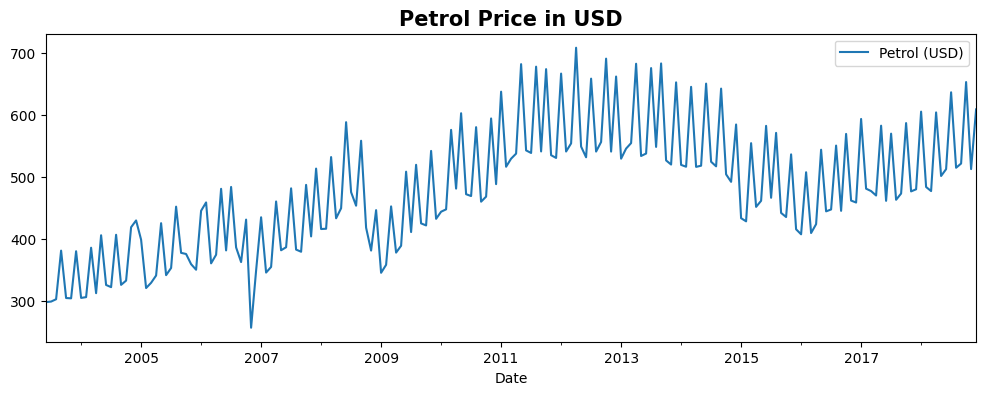

In [9]:
# Visulalize the time series.

Price.plot(figsize = (12, 4))

plt.legend(loc = 'best')

plt.title('Petrol Price in USD', fontweight = 'bold', size = 15)

plt.show(block = False)

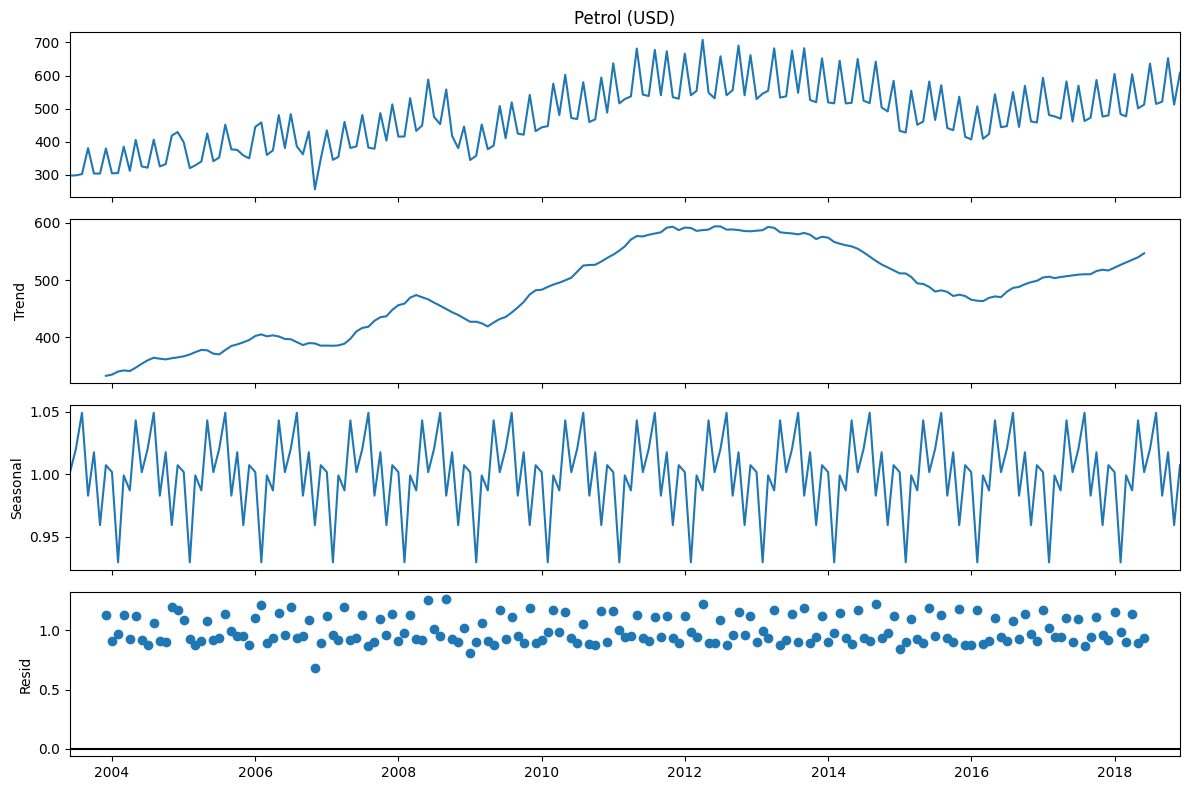

In [10]:
# Decomposing the time series.

rcParams['figure.figsize'] = 12, 8

decomposition = sm.tsa.seasonal_decompose(Price['Petrol (USD)'], model = 'multiplicative')

fig = decomposition.plot()

plt.show()

In [11]:
# Splitting data into train and test data.

train1 = Price.head(171)

test1 = Price.tail(16)

### **Auto Regressive Model (AR)**


Let's check if the given time series is stationary or not. This can be done by using two methods as:

1. Augmented Dickey-Fuller (ADF) test.
2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test.

**ADF test:**

* Null Hypothesis (H0): The series is not stationary if p−value > 0.05.
* Alternate Hypothesis (H1): The series is stationary if p−value <= 0.05.

**KPSS test:**

* Null Hypothesis (H0): The series is stationary if p−value > 0.05.
* Alternate Hypothesis (H1): The series is not stationary if p−value <= 0.05.

In [12]:
# ADF test.

test_adf = adfuller(Price['Petrol (USD)'])

print('ADF Statistic: %f' % test_adf[0])

print('Critical Values @ 0.05: %.2f' % test_adf[4]['5%'])

print('p-value: %f' % test_adf[1]) 

# The series is not stationary.

ADF Statistic: -1.643827
Critical Values @ 0.05: -2.88
p-value: 0.460262


In [13]:
# KPSS test.

test_kpss = kpss(Price['Petrol (USD)'])

print('KPSS Statistic: %f' % test_kpss[0])

print('Critical Values @ 0.05: %.2f' % test_kpss[3]['5%'])

print('p-value: %f' % test_kpss[1])

# The series is not stationary.

KPSS Statistic: 1.275528
Critical Values @ 0.05: 0.46
p-value: 0.010000


/tmp/ipykernel_33/358260949.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  test_kpss = kpss(Price['Petrol (USD)'])


Let's convert this non-stationary series into stationary series are by applying Differencing and Transformation.

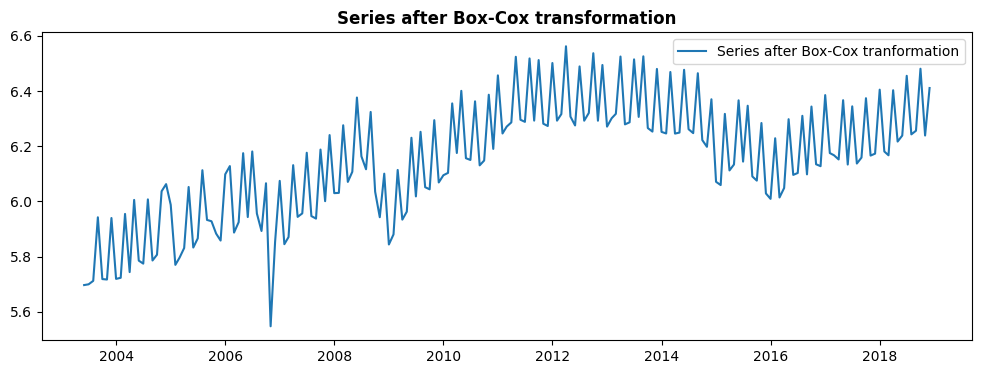

In [14]:
# Box-Cox Transformation,

boxcox_df = pd.Series(boxcox(Price['Petrol (USD)'], lmbda = 0), index = Price.index)

plt.figure(figsize = (12,4))

plt.plot(boxcox_df, label = 'Series after Box-Cox tranformation')

plt.legend(loc = 'best')

plt.title('Series after Box-Cox transformation', fontweight = 'bold')

plt.show()

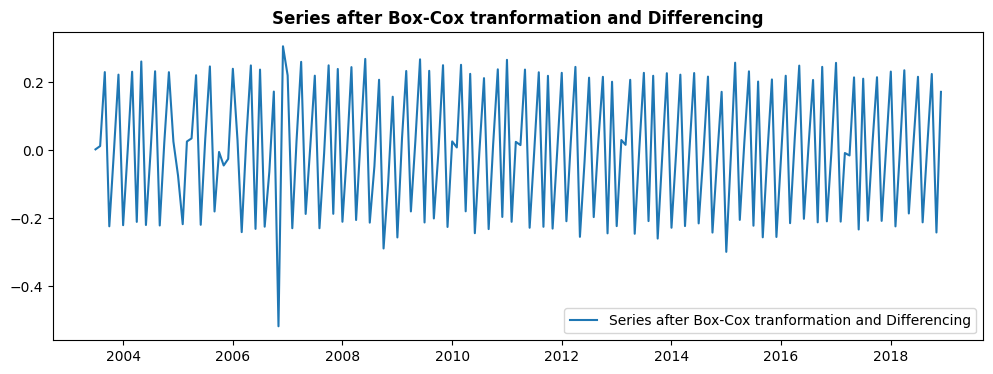

In [15]:
# Applying Differencing to remove both Trend and seasonality in a time series.

diff_df = pd.Series(boxcox_df - boxcox_df.shift(), Price.index)

plt.figure(figsize = (12,4))

plt.plot(diff_df, label = 'Series after Box-Cox tranformation and Differencing')

plt.legend(loc = 'best')

plt.title('Series after Box-Cox tranformation and Differencing', fontweight = 'bold')

plt.show()

In [16]:
# Checking if the are any missing values.

diff_df.isnull().sum()

1

In [17]:
# Removing missing values.

diff_df.dropna(inplace = True)

In [18]:
# Converting series to dataframe.

diff_df = diff_df.to_frame()

diff_df

In [20]:
# Checking for stationarity.

test_adf = adfuller(diff_df)

print('ADF Statistic: %f' % test_adf[0])

print('Critical Values @ 0.05: %.2f' % test_adf[4]['5%'])

print('p-value: %f' % test_adf[1])

# The series is now stationary.

ADF Statistic: -3.688144
Critical Values @ 0.05: -2.88
p-value: 0.004283


In [21]:
# Checking for stationarity.

test_kpss = kpss(diff_df)

print('KPSS Statistic: %f' % test_kpss[0])

print('Critical Values @ 0.05: %.2f' % test_kpss[3]['5%'])

print('p-value: %f' % test_kpss[1])

# The series is now stationary.

KPSS Statistic: 0.087108
Critical Values @ 0.05: 0.46
p-value: 0.100000


/tmp/ipykernel_33/2830487084.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  test_kpss = kpss(diff_df)


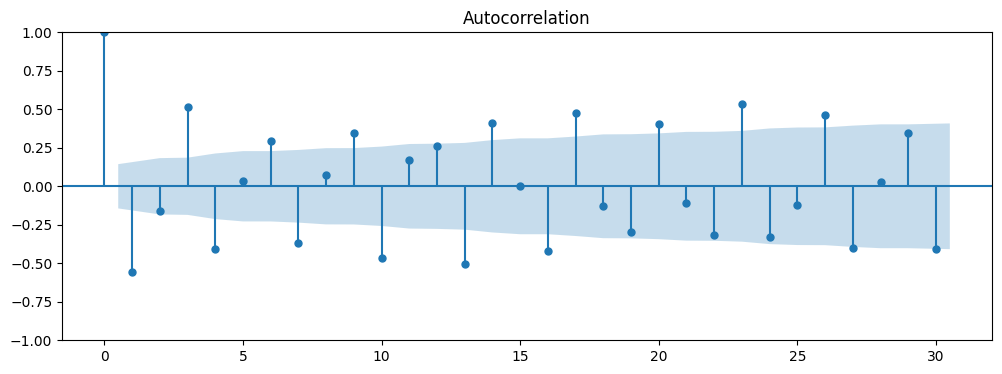

In [22]:
# Plotting Autocorrelation plot.

plt.figure(figsize = (12,4))

plot_acf(diff_df, ax = plt.gca(), lags = 30)

plt.show()

# q = 2

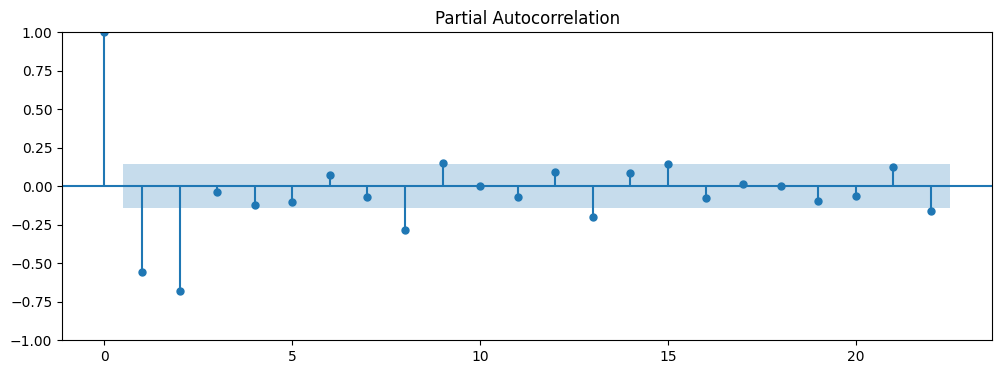

In [23]:
# Plotting Partial autocorrelation plot.

plt.figure(figsize = (12,4))

plot_pacf(diff_df, ax = plt.gca(), lags = 22)

plt.show()

# p = 3

### **Auto Regressive Model (AR)**

In [24]:
diff_train = diff_df.head(170)

diff_test = diff_df.head(16)

In [25]:
# Building Auto Regressive model.

model_AR = ARIMA(diff_train, order = (3, 0, 0))

model_fit_AR = model_AR.fit()

print(model_fit_AR.params)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


const     0.003016
ar.L1    -0.947069
ar.L2    -0.688046
ar.L3    -0.039546
sigma2    0.014330
dtype: float64


In [26]:
# Forecast future price.

forecast_steps = 16  # Specify the number of steps to forecast

forecast_AR = model_fit_AR.forecast(steps = forecast_steps)

# Print the forecasted price

print(f"Forecasted petrol price in USD for next 16 months:")

print(forecast_AR)

Forecasted petrol price in USD for next 16 months:
2017-09-01    0.068476
2017-10-01    0.077520
2017-11-01   -0.104267
2017-12-01    0.050768
2018-01-01    0.028660
2018-02-01   -0.049885
2018-03-01    0.033583
2018-04-01    0.009450
2018-05-01   -0.022018
2018-06-01    0.021088
2018-07-01    0.002869
2018-08-01   -0.008291
2018-09-01    0.013109
2018-10-01    0.001241
2018-11-01   -0.001802
2018-12-01    0.008400
Freq: MS, Name: predicted_mean, dtype: float64


In [27]:
# Converting series to dataframe.

forecast_AR = forecast_AR.to_frame()

forecast_AR

,predicted_mean
2017-09-01,0.068476
2017-10-01,0.077520
2017-11-01,-0.104267
2017-12-01,0.050768
2018-01-01,0.028660
2018-02-01,-0.049885
2018-03-01,0.033583
2018-04-01,0.009450
2018-05-01,-0.022018
2018-06-01,0.021088


In [28]:
# Generating RMSE and MAPE values.

rmse = np.sqrt(mean_squared_error(diff_test,forecast_AR))

mape = mean_absolute_percentage_error(diff_test,forecast_AR)

results = pd.DataFrame({'Method':['Auto Regression'], 'MAPE':[mape], 'RMSE':[rmse]})

results = results[['Method', 'RMSE', 'MAPE']]

results

,Method,RMSE,MAPE
0,Auto Regression,0.204432,3.93426


In [29]:
# Rename column.

diff_train.rename(columns = {0:'Price (USD)'}, inplace = True)

# Reset the index of the dataframe.

diff_train = diff_train.reset_index(drop = True)

diff_train

,Price (USD)
0,0.002783
1,0.012511
2,0.230431
3,-0.223971
4,-0.001611
...,...
165,-0.015131
166,0.214848
167,-0.233286
168,0.210985


In [30]:
# Rename column.

diff_test.rename(columns={0:'Price (USD)'}, inplace = True)

# Reset the index of the dataframe.

diff_test = diff_test.reset_index(drop = True)

diff_test

,Price (USD)
0,0.002783
1,0.012511
2,0.230431
3,-0.223971
4,-0.001611
5,0.222953
6,-0.220685
7,0.003998
8,0.231532
9,-0.210883


In [31]:
# Rename column.

forecast_AR.rename(columns={'predicted_mean':'Price (USD)'}, inplace = True)

# Reset the index of the dataframe.

forecast_AR = forecast_AR.reset_index(drop = False)

forecast_AR

,index,Price (USD)
0,2017-09-01,0.068476
1,2017-10-01,0.077520
2,2017-11-01,-0.104267
3,2017-12-01,0.050768
4,2018-01-01,0.028660
5,2018-02-01,-0.049885
6,2018-03-01,0.033583
7,2018-04-01,0.009450
8,2018-05-01,-0.022018
9,2018-06-01,0.021088


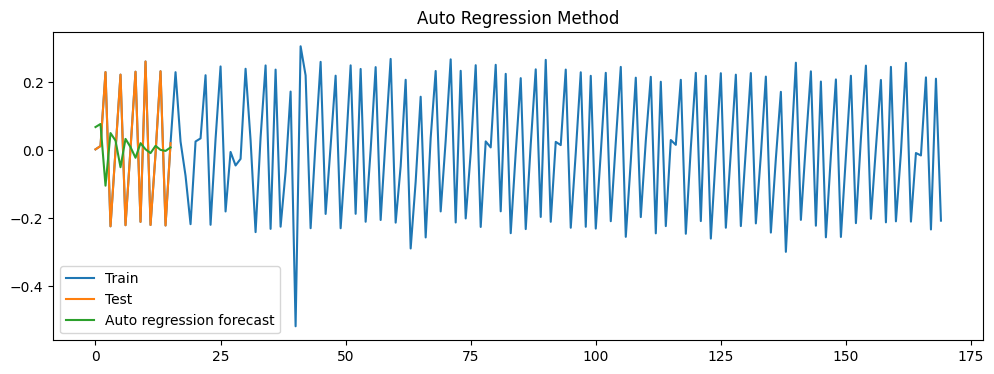

In [32]:
# Plotting forecast made by AR model.

plt.figure(figsize = (12,4))

plt.plot(diff_train['Price (USD)'], label = 'Train')

plt.plot(diff_test['Price (USD)'], label = 'Test')

plt.plot(forecast_AR['Price (USD)'], label = 'Auto regression forecast')

plt.legend(loc = 'best')

plt.title('Auto Regression Method')

plt.show()

### **Moving Average Method (MA)**

In [33]:
# Building Auto Regressive model.

model_MA = ARIMA(diff_train, order = (0, 0, 2))

model_fit_MA = model_MA.fit()

print(model_fit_MA.params)

const     0.002932
ma.L1    -1.063189
ma.L2     0.325662
sigma2    0.016444
dtype: float64


In [34]:
# Forecast future price.

forecast_steps = 16  # Specify the number of steps to forecast

forecast_MA = model_fit_MA.forecast(steps = forecast_steps)

# Print the forecasted price

print(f"Forecasted petrol price in USD for next 16 months:")

print(forecast_MA)

Forecasted petrol price in USD for next 16 months:
170    0.125683
171   -0.024765
172    0.002932
173    0.002932
174    0.002932
175    0.002932
176    0.002932
177    0.002932
178    0.002932
179    0.002932
180    0.002932
181    0.002932
182    0.002932
183    0.002932
184    0.002932
185    0.002932
Name: predicted_mean, dtype: float64


In [35]:
# Converting series to dataframe.

forecast_MA = forecast_MA.to_frame()

forecast_MA

,predicted_mean
170,0.125683
171,-0.024765
172,0.002932
173,0.002932
174,0.002932
175,0.002932
176,0.002932
177,0.002932
178,0.002932
179,0.002932


In [36]:
# Generating RMSE and MAPE values.

rmse = np.sqrt(mean_squared_error(diff_test,forecast_MA))

mape = mean_absolute_percentage_error(diff_test,forecast_MA)

model_results = pd.DataFrame({'Method':['Moving Average'], 'MAPE':[mape], 'RMSE':[rmse]})

results = pd.concat([results, model_results])

results = results[['Method', 'RMSE', 'MAPE']]

results

,Method,RMSE,MAPE
0,Auto Regression,0.204432,3.934260
0,Moving Average,0.183131,3.897627


In [37]:
# Rename column.

diff_train.rename(columns = {0:'Price (USD)'}, inplace = True)

# Reset the index of the dataframe.

diff_train = diff_train.reset_index(drop = True)

diff_train

,Price (USD)
0,0.002783
1,0.012511
2,0.230431
3,-0.223971
4,-0.001611
...,...
165,-0.015131
166,0.214848
167,-0.233286
168,0.210985


In [38]:
# Rename column.

diff_test.rename(columns={0:'Price (USD)'}, inplace = True)

# Reset the index of the dataframe.

diff_test = diff_test.reset_index(drop = True)

diff_test

,Price (USD)
0,0.002783
1,0.012511
2,0.230431
3,-0.223971
4,-0.001611
5,0.222953
6,-0.220685
7,0.003998
8,0.231532
9,-0.210883


In [39]:
# Rename column.

forecast_MA.rename(columns={'predicted_mean':'Price (USD)'}, inplace = True)

# Reset the index of the dataframe.

forecast_MA = forecast_MA.reset_index(drop = False)

forecast_MA

,index,Price (USD)
0,170,0.125683
1,171,-0.024765
2,172,0.002932
3,173,0.002932
4,174,0.002932
5,175,0.002932
6,176,0.002932
7,177,0.002932
8,178,0.002932
9,179,0.002932


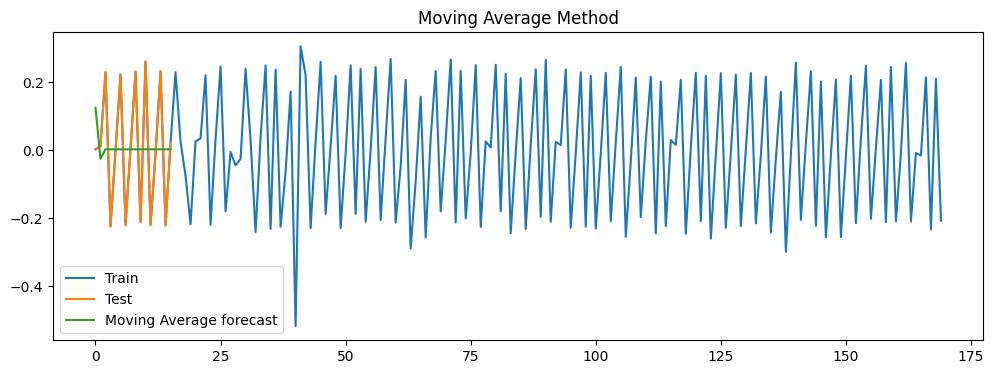

In [40]:
# Plotting forecast made by AR model.

plt.figure(figsize = (12,4))

plt.plot(diff_train['Price (USD)'], label = 'Train')

plt.plot(diff_test['Price (USD)'], label = 'Test')

plt.plot(forecast_MA['Price (USD)'], label = 'Moving Average forecast')

plt.legend(loc = 'best')

plt.title('Moving Average Method')

plt.show()

### **Auto Regressive Moving Average (ARMA) Model**

In [41]:
# Building Auto Regressive model.

model_ARMA = ARIMA(diff_train, order = (3, 0, 2))

model_fit_ARMA = model_ARMA.fit()

print(model_fit_ARMA.params)

const     0.002779
ar.L1    -0.382734
ar.L2    -0.055176
ar.L3     0.383335
ma.L1    -0.589073
ma.L2    -0.200541
sigma2    0.013903
dtype: float64


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
# Forecast future price.

forecast_steps = 16  # Specify the number of steps to forecast

forecast_ARMA = model_fit_ARMA.forecast(steps = forecast_steps)

# Print the forecasted price

print(f"Forecasted petrol price in USD for next 16 months:")

print(forecast_ARMA)

Forecasted petrol price in USD for next 16 months:
170    0.048237
171    0.108767
172   -0.120835
173    0.061668
174    0.027690
175   -0.057390
176    0.047008
177   -0.001279
178   -0.021173
179    0.029125
180   -0.007538
181   -0.003907
182    0.016007
183   -0.005869
184    0.002797
185    0.008320
Name: predicted_mean, dtype: float64


In [43]:
# Converting series to dataframe.

forecast_ARMA = forecast_ARMA.to_frame()

forecast_ARMA

,predicted_mean
170,0.048237
171,0.108767
172,-0.120835
173,0.061668
174,0.027690
175,-0.057390
176,0.047008
177,-0.001279
178,-0.021173
179,0.029125


In [44]:
# Generating RMSE and MAPE values.

rmse = np.sqrt(mean_squared_error(diff_test,forecast_ARMA))

mape = mean_absolute_percentage_error(diff_test,forecast_ARMA)

model_results = pd.DataFrame({'Method':['Auto Regressive Moving Average'], 'MAPE':[mape], 'RMSE':[rmse]})

results = pd.concat([results, model_results])

results = results[['Method', 'RMSE', 'MAPE']]

results

,Method,RMSE,MAPE
0,Auto Regression,0.204432,3.934260
0,Moving Average,0.183131,3.897627
0,Auto Regressive Moving Average,0.211588,3.634941


In [47]:
# Rename column.

forecast_ARMA.rename(columns = {'predicted_mean':'Price (USD)'}, inplace = True)

# Reset the index of the dataframe.

forecast_ARMA = forecast_ARMA.reset_index(drop = False)

forecast_ARMA

,index,Price (USD)
0,170,0.048237
1,171,0.108767
2,172,-0.120835
3,173,0.061668
4,174,0.027690
5,175,-0.057390
6,176,0.047008
7,177,-0.001279
8,178,-0.021173
9,179,0.029125


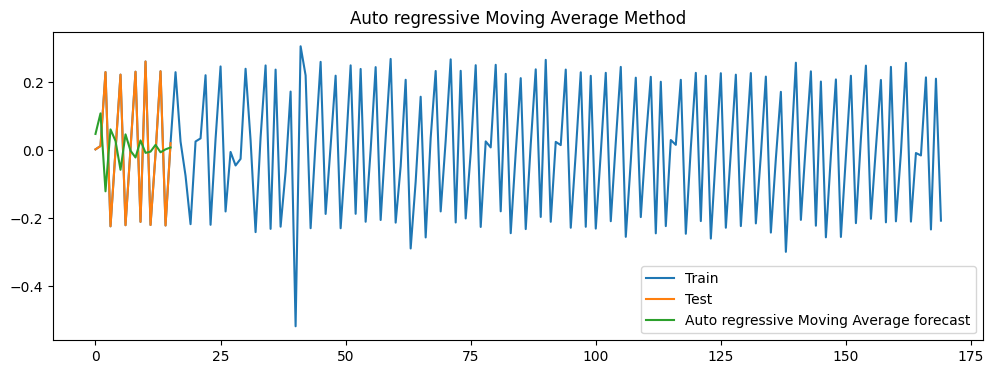

In [48]:
# Plotting forecast made by AR model.

plt.figure(figsize = (12,4))

plt.plot(diff_train['Price (USD)'], label = 'Train')

plt.plot(diff_test['Price (USD)'], label = 'Test')

plt.plot(forecast_ARMA['Price (USD)'], label = 'Auto regressive Moving Average forecast')

plt.legend(loc = 'best')

plt.title('Auto regressive Moving Average Method')

plt.show()

### **Auto Regressive Integrated Moving Average (ARIMA) Model**

In [49]:
# Building Auto Regressive model.

model_ARIMA = ARIMA(diff_train, order = (3, 1, 2))

model_fit_ARIMA = model_ARIMA.fit()

print(model_fit_ARIMA.params)

ar.L1    -1.869809
ar.L2    -1.513916
ar.L3    -0.600381
ma.L1    -0.001047
ma.L2    -0.998949
sigma2    0.014043
dtype: float64


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [50]:
# Forecast future price.

forecast_steps = 16  # Specify the number of steps to forecast

forecast_ARIMA = model_fit_ARIMA.forecast(steps = forecast_steps)

# Print the forecasted price

print(f"Forecasted petrol price in USD for next 16 months:")

print(forecast_ARIMA)

Forecasted petrol price in USD for next 16 months:
170    0.051291
171    0.106505
172   -0.137114
173    0.079548
174    0.010101
175   -0.041789
176    0.030293
177    0.015765
178   -0.035043
179    0.038676
180   -0.013523
181    0.002979
182    0.006889
183    0.005935
184   -0.008108
185    0.017246
Name: predicted_mean, dtype: float64


In [51]:
# Converting series to dataframe.

forecast_ARIMA = forecast_ARIMA.to_frame()

forecast_ARIMA

,predicted_mean
170,0.051291
171,0.106505
172,-0.137114
173,0.079548
174,0.010101
175,-0.041789
176,0.030293
177,0.015765
178,-0.035043
179,0.038676


In [52]:
# Generating RMSE and MAPE values.

rmse = np.sqrt(mean_squared_error(diff_test,forecast_ARIMA))

mape = mean_absolute_percentage_error(diff_test,forecast_ARIMA)

model_results = pd.DataFrame({'Method':['Auto Regressive Integrated Moving Average'], 'MAPE':[mape], 'RMSE':[rmse]})

results = pd.concat([results, model_results])

results = results[['Method', 'RMSE', 'MAPE']]

results

,Method,RMSE,MAPE
0,Auto Regression,0.204432,3.934260
0,Moving Average,0.183131,3.897627
0,Auto Regressive Moving Average,0.211588,3.634941
0,Auto Regressive Integrated Moving Average,0.213301,3.036065


In [53]:
# Rename column.

forecast_ARIMA.rename(columns = {'predicted_mean':'Price (USD)'}, inplace = True)

# Reset the index of the dataframe.

forecast_ARIMA = forecast_ARIMA.reset_index(drop = False)

forecast_ARIMA

,index,Price (USD)
0,170,0.051291
1,171,0.106505
2,172,-0.137114
3,173,0.079548
4,174,0.010101
5,175,-0.041789
6,176,0.030293
7,177,0.015765
8,178,-0.035043
9,179,0.038676


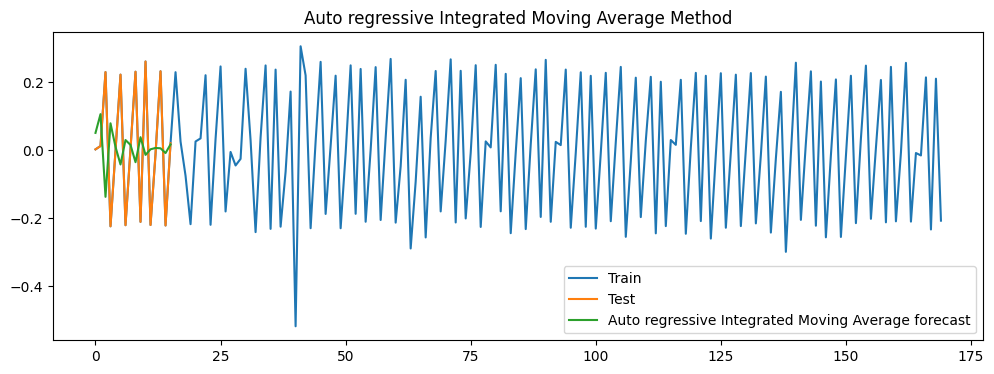

In [54]:
# Plotting forecast made by AR model.

plt.figure(figsize = (12,4))

plt.plot(diff_train['Price (USD)'], label = 'Train')

plt.plot(diff_test['Price (USD)'], label = 'Test')

plt.plot(forecast_ARIMA['Price (USD)'], label = 'Auto regressive Integrated Moving Average forecast')

plt.legend(loc = 'best')

plt.title('Auto regressive Integrated Moving Average Method')

plt.show()

In [ ]:
#converting back
#creating a time serie
predictions_ARIMA_diff=pd.Series(model_fit.fittedvalues,copy=True)
#convert to cumulative sum
predictions_ARIMA_diff_cumsum=predictions_ARIMA_diff.cumsum()

predictions_ARIMA_log=pd.Series(diff_train['Price (USD)'],index=diff_train.index)
predictions_ARIMA_log=(predictions_ARIMA_log).add(predictions_ARIMA_diff_cumsum,fill_value=0)
#plotting
predictions_ARIMA=np.exp(predictions_ARIMA_log)
predictions_ARIMA


### **Seasonal auto regressive integrated moving average (SARIMA)**

In [ ]:
# Stepwise search to minimize aic.

model = auto_arima(diff_train, start_p = 0, d = 1, start_q = 0, max_p = 5, max_d = 5, max_q = 5, start_P = 0, D = 1, start_Q = 0, max_P = 5, max_D = 5, max_Q = 5, m = 12, seasonal = True, error_action = 'warn', trace = True, supress_warnings = True, stepwise = True, random_state = 20, n_fits = 50)

model.summary()

In [ ]:
# Building SARIMA model.

model_SARIMA = SARIMAX(diff_train, order = (5, 1, 0), seasonal_order = (4, 1, 1, 12))

model_fit_SARIMA = model_SARIMA.fit(method = 'cg')

print(model_fit_SARIMA.params)

In [ ]:
# Forecast future price.

forecast_steps = 16  # Specify the number of steps to forecast

forecast_SARIMA = model_fit_SARIMA.forecast(steps = forecast_steps)

# Print the forecasted price

print(f"Forecasted petrol price in USD for next 16 months:")

print(forecast_SARIMA)

In [ ]:
# Converting series to dataframe.

forecast_SARIMA = forecast_SARIMA.to_frame()

forecast_SARIMA

In [ ]:
# Generating RMSE and MAPE values.

rmse = np.sqrt(mean_squared_error(diff_test,forecast_SARIMA))

mape = mean_absolute_percentage_error(diff_test,forecast_SARIMA)

model_results = pd.DataFrame({'Method':['Seasonal auto regressive integrated moving average'], 'MAPE':[mape], 'RMSE':[rmse]})

results = pd.concat([results, model_results])

results = results[['Method', 'RMSE', 'MAPE']]

results

In [ ]:
# Rename column.

forecast_SARIMA.rename(columns = {'predicted_mean':'Price (USD)'}, inplace = True)

# Reset the index of the dataframe.

forecast_SARIMA = forecast_SARIMA.reset_index(drop = False)

forecast_SARIMA

In [ ]:
# Plotting forecast made by AR model.

plt.figure(figsize = (12,4))

plt.plot(diff_train['Price (USD)'], label = 'Train')

plt.plot(diff_test['Price (USD)'], label = 'Test')

plt.plot(forecast_SARIMA['Price (USD)'], label = 'Seasonal auto regressive integrated moving average forecast')

plt.legend(loc = 'best')

plt.title('Seasonal auto regressive integrated moving average')

plt.show()

### **Conclusion**:

Out of all methods, ARIMA method is able to predict the petrol prices closer to the actual values. Hence forecast made by ARIMA method is best for the given time series data.